Множество точек E:
P1: (4.36, 0.26)
P2: (5.50, 4.35)
P3: (4.20, 3.30)
P4: (2.05, 6.19)
P5: (3.00, 2.67)
P6: (6.21, 5.29)
P7: (1.35, 5.14)
P8: (1.84, 7.85)
P9: (8.54, 4.94)
P10: (8.47, 0.80)

a) Ближайшая пара точек: P2 и P6
   Расстояние между ними: 1.1794


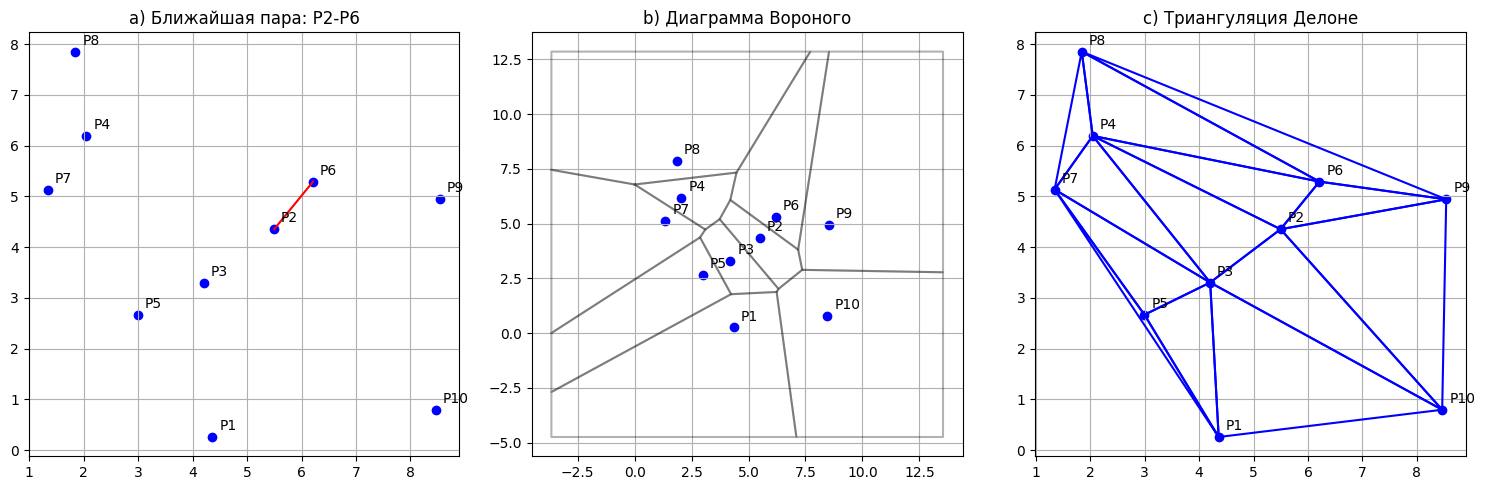


b) Диаграмма Вороного построена

c) Триангуляция Делоне построена
   Количество рёбер в триангуляции: 22
   Количество треугольников в триангуляции: 13


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from collections import defaultdict

# Задаем множество точек E
np.random.seed(2)
E = np.random.rand(10, 2) * 10  # 10 точек в диапазоне [0, 10]

print("Множество точек E:")
for i, point in enumerate(E):
    print(f"P{i+1}: ({point[0]:.2f}, {point[1]:.2f})")

# a) Найти ближайшую пару точек
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def find_closest_pair_brute_force(points):
    n = len(points)
    if n < 2:
        return None, float('inf')
    
    min_dist = float('inf')
    closest_pair = None
    
    for i in range(n):
        for j in range(i+1, n):
            dist = euclidean_distance(points[i], points[j])
            if dist < min_dist:
                min_dist = dist
                closest_pair = (i, j)
    
    return closest_pair, min_dist

closest_pair, min_dist = find_closest_pair_brute_force(E)
print(f"\na) Ближайшая пара точек: P{closest_pair[0]+1} и P{closest_pair[1]+1}")
print(f"   Расстояние между ними: {min_dist:.4f}")

# b) Построение диаграммы Вороного
# Алгоритм Форчана
def compute_voronoi_regions(points):
    n = len(points)
    regions = []
    
    # Определим границы для ограничения регионов
    min_x, min_y = np.min(points, axis=0) - 5
    max_x, max_y = np.max(points, axis=0) + 5
    boundary = [(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)]
    
    for i in range(n):
        region = boundary.copy()
        for j in range(n):
            if i != j:
                # Вычисляем перпендикулярную биссектрису между точками i и j
                bisector = compute_perpendicular_bisector(points[i], points[j])
                region = clip_polygon_by_line(region, *bisector, points[i], points[j])
        regions.append(region)
    
    return regions

def compute_perpendicular_bisector(p1, p2):
    # Середина отрезка
    mid_x = (p1[0] + p2[0]) / 2
    mid_y = (p1[1] + p2[1]) / 2
    
    # Вектор от p1 к p2
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    
    # Перпендикулярный вектор
    perp_dx = -dy
    perp_dy = dx
    
    # Возвращаем точки линии биссектрисы
    return (mid_x, mid_y), (mid_x + perp_dx, mid_y + perp_dy)

def clip_polygon_by_line(polygon, line_point, line_direction, site1, site2):
    # Определяем, какая сторона линии должна быть сохранена
    # (та, на которой находится site1)
    def is_point_on_positive_side(point):
        # Векторное произведение для определения стороны линии
        v1 = (line_direction[0] - line_point[0], line_direction[1] - line_point[1])
        v2 = (point[0] - line_point[0], point[1] - line_point[1])
        cross_product = v1[0] * v2[1] - v1[1] * v2[0]
        
        # Если site1 с той же стороны от линии, что и точка
        v_site = (site1[0] - line_point[0], site1[1] - line_point[1])
        site_cross = v1[0] * v_site[1] - v1[1] * v_site[0]
        
        return (cross_product > 0 and site_cross > 0) or (cross_product < 0 and site_cross < 0)
    
    result = []
    for i in range(len(polygon)):
        current = polygon[i]
        previous = polygon[i-1]
        
        current_inside = is_point_on_positive_side(current)
        previous_inside = is_point_on_positive_side(previous)
        
        if current_inside:
            if not previous_inside:
                # Добавляем точку пересечения
                intersection = line_intersection(previous, current, line_point, line_direction)
                if intersection:
                    result.append(intersection)
            result.append(current)
        elif previous_inside:
            # Добавляем точку пересечения
            intersection = line_intersection(previous, current, line_point, line_direction)
            if intersection:
                result.append(intersection)
    
    return result

def line_intersection(p1, p2, p3, p4):
    # Находим точку пересечения двух отрезков
    denominator = (p4[1] - p3[1]) * (p2[0] - p1[0]) - (p4[0] - p3[0]) * (p2[1] - p1[1])
    
    if denominator == 0:
        return None  # Параллельные линии
    
    ua = ((p4[0] - p3[0]) * (p1[1] - p3[1]) - (p4[1] - p3[1]) * (p1[0] - p3[0])) / denominator
    
    intersection_x = p1[0] + ua * (p2[0] - p1[0])
    intersection_y = p1[1] + ua * (p2[1] - p1[1])
    
    return (intersection_x, intersection_y)

# Рекурсивный алгоритм "разделяй и властвуй" для диаграммы Вороного
def voronoi_divide_and_conquer(points):
    if len(points) <= 3:
        # Базовый случай: используем прямой алгоритм для небольшого числа точек
        return compute_voronoi_regions(points)
    
    # Разделяем точки на две половины по x-координате
    sorted_points = sorted(points, key=lambda p: p[0])
    mid = len(sorted_points) // 2
    
    left_points = sorted_points[:mid]
    right_points = sorted_points[mid:]
    
    # Рекурсивно строим диаграмму для левой и правой части
    left_voronoi = voronoi_divide_and_conquer(left_points)
    right_voronoi = voronoi_divide_and_conquer(right_points)
    
    # Объединяем две диаграммы
    # (В настоящей реализации это сложно, поэтому мы используем упрощенный подход)
    return merge_voronoi_diagrams(left_voronoi, right_voronoi, left_points, right_points)

def merge_voronoi_diagrams(left_voronoi, right_voronoi, left_points, right_points):
    # Упрощенное объединение: вместо реального слияния просто пересчитываем заново
    all_points = np.vstack((left_points, right_points))
    return compute_voronoi_regions(all_points)

# c) Построение триангуляции Делоне
def compute_delaunay_triangulation(points):
    # Используем двойственность с диаграммой Вороного
    # Если две ячейки Вороного имеют общую границу, 
    # соответствующие точки соединяются ребром в триангуляции Делоне
    
    n = len(points)
    edges = set()
    
    # Находим пары точек, которые должны быть соединены ребрами
    for i in range(n):
        for j in range(i+1, n):
            # Проверяем условие пустого круга для треугольника
            if is_delaunay_edge(points, i, j):
                edges.add((i, j))
    
    return edges

def is_delaunay_edge(points, i, j):
    # Проверяем, удовлетворяет ли ребро между точками i и j критерию пустого круга
    # Для каждой другой точки проверяем, что она не находится внутри окружности,
    # построенной на диаметре i-j
    
    for k in range(len(points)):
        if k != i and k != j:
            # В простейшем случае: если точки i и j образуют диаметр окружности,
            # проверяем, что точка k находится за пределами этой окружности
            if is_point_in_circumcircle(points[i], points[j], points[i], points[k]):
                return False
    
    return True

def is_point_in_circumcircle(center1, center2, point_on_circle, test_point):
    # Проверяем, находится ли test_point внутри окружности,
    # построенной на диаметре center1-center2 и проходящей через point_on_circle
    
    # Находим центр и радиус этой окружности
    center_x = (center1[0] + center2[0]) / 2
    center_y = (center1[1] + center2[1]) / 2
    radius_squared = ((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2) / 4
    
    # Проверяем, находится ли test_point внутри окружности
    dx = test_point[0] - center_x
    dy = test_point[1] - center_y
    dist_squared = dx**2 + dy**2
    
    return dist_squared < radius_squared

#  алгоритм триангуляции Делоне
def improved_delaunay_triangulation(points):
    """Реализация триангуляции Делоне с формированием треугольников"""
    n = len(points)
    
    # Находим выпуклую оболочку точек (для простоты используем библиотеку)
    from scipy.spatial import ConvexHull, Delaunay
    
    # Создаем триангуляцию Делоне
    tri = Delaunay(points)
    
    # Получаем треугольники
    triangles = tri.simplices
    
    # Преобразуем в список рёбер
    edges = set()
    for triangle in triangles:
        # Для каждого треугольника добавляем его стороны как рёбра
        for i in range(3):
            # Убедимся, что точки с меньшим индексом идут первыми в паре
            p1, p2 = min(triangle[i], triangle[(i+1)%3]), max(triangle[i], triangle[(i+1)%3])
            edges.add((p1, p2))
    
    return edges, triangles

# Визуализация результатов
plt.figure(figsize=(15, 5))

# Визуализация ближайшей пары точек
plt.subplot(1, 3, 1)
plt.scatter(E[:, 0], E[:, 1], color='blue')
for i, point in enumerate(E):
    plt.annotate(f'P{i+1}', (point[0], point[1]), xytext=(5, 5), textcoords='offset points')

# Подсветим ближайшую пару
plt.plot([E[closest_pair[0]][0], E[closest_pair[1]][0]], 
         [E[closest_pair[0]][1], E[closest_pair[1]][1]], color='red')
plt.title(f'a) Ближайшая пара: P{closest_pair[0]+1}-P{closest_pair[1]+1}')
plt.grid(True)

# Визуализация диаграммы Вороного
plt.subplot(1, 3, 2)
voronoi_regions = compute_voronoi_regions(E)

# Рисуем регионы Вороного
for region in voronoi_regions:
    if len(region) > 2:  # Убеждаемся, что регион не вырожден
        region_x = [p[0] for p in region] + [region[0][0]]  # Замыкаем полигон
        region_y = [p[1] for p in region] + [region[0][1]]
        plt.plot(region_x, region_y, 'k-', alpha=0.3)

# Рисуем исходные точки
plt.scatter(E[:, 0], E[:, 1], color='blue')
for i, point in enumerate(E):
    plt.annotate(f'P{i+1}', (point[0], point[1]), xytext=(5, 5), textcoords='offset points')
plt.title('b) Диаграмма Вороного')
plt.grid(True)

# ИСПРАВЛЕНО: Улучшенная визуализация триангуляции Делоне
plt.subplot(1, 3, 3)
delaunay_edges, triangles = improved_delaunay_triangulation(E)

# Рисуем треугольники
for triangle in triangles:
    # Получаем координаты треугольника
    x = [E[vertex][0] for vertex in triangle]
    y = [E[vertex][1] for vertex in triangle]
    # Замыкаем полигон, добавляя первую точку в конец
    x.append(x[0])
    y.append(y[0])
    plt.plot(x, y, 'b-')

# Рисуем исходные точки
plt.scatter(E[:, 0], E[:, 1], color='blue')
for i, point in enumerate(E):
    plt.annotate(f'P{i+1}', (point[0], point[1]), xytext=(5, 5), textcoords='offset points')
plt.title('c) Триангуляция Делоне')
plt.grid(True)

plt.tight_layout()
plt.savefig('geometric_analysis.png')
plt.show()

# Вывод результатов
print("\nb) Диаграмма Вороного построена")
print("\nc) Триангуляция Делоне построена")
print(f"   Количество рёбер в триангуляции: {len(delaunay_edges)}")
print(f"   Количество треугольников в триангуляции: {len(triangles)}")